In [1]:
# Basic libraries
import os
from PIL import Image
import gc

In [2]:
# Statistical libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [3]:
# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [4]:
# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import GlobalAveragePooling2D, Input

C:\Users\josep\AppData\Local\Temp\ipykernel_4000\2646505697.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [6]:
from kerastuner.tuners import RandomSearch

In [7]:
# Specify the directory
bach_dir = 'music_data/midiclassics/Bach'
beethoven_dir = 'music_data/midiclassics/Beethoven'
chopin_dir = 'music_data/midiclassics/Chopin'
mozart_dir = 'music_data/midiclassics/Mozart'

composer_dirs = [bach_dir, beethoven_dir, chopin_dir, mozart_dir]

In [8]:
def compile_midi_files(directory):
    # Initialize an empty list to store the paths of all MIDI files
    midi_files = []

    # Use os.walk to iterate over each subdirectory in the current directory
        # 'root' is the path to the current directory
        # 'dirs' is a list of the names of the subdirectories in 'root'
        # 'files' is a list of the names of the non-directory files in 'root'
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is a MIDI file
            if file.endswith('.mid'):
                # If it is, construct the full path to the file and add it to the list
                midi_files.append(os.path.join(root, file))

    # Return the list of all MIDI files
    return midi_files

# Compile all MIDI files from each composer
bach_midi_files = compile_midi_files(bach_dir)
beethoven_midi_files = compile_midi_files(beethoven_dir)
chopin_midi_files = compile_midi_files(chopin_dir)
mozart_midi_files = compile_midi_files(mozart_dir)

# Print the number of MIDI files for each composer
print(f'Bach MIDI files: {len(bach_midi_files)}')
print(f'Beethoven MIDI files: {len(beethoven_midi_files)}')
print(f'Chopin MIDI files: {len(chopin_midi_files)}')
print(f'Mozart MIDI files: {len(mozart_midi_files)}')

Bach MIDI files: 97
Beethoven MIDI files: 212
Chopin MIDI files: 136
Mozart MIDI files: 257


In [9]:
# Balance Directoriries @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

import shutil
import random

# Directory paths
base_dir = r'C:\Users\josep\midiclassics'
directories = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
directory_paths = [os.path.join(base_dir, d) for d in directories]

# Get the maximum number of files in any folder
max_size = max([len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]) for dir_path in directory_paths])
max_size = 257
def balance_directory(directory, target_size):
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    current_size = len(files)

    while current_size < target_size:
        # Randomly pick a file to duplicate
        file_to_duplicate = random.choice(files)
        base, extension = os.path.splitext(file_to_duplicate)
        new_file = f"{base}_copy_{current_size}{extension}"
        
        # Copy the file
        shutil.copy(os.path.join(directory, file_to_duplicate), os.path.join(directory, new_file))
        
        files.append(new_file)
        current_size += 1

# Balance each directory
for dir_path in directory_paths:
    balance_directory(dir_path, max_size)

In [10]:
# Check Balanced File Count

# Directory paths
base_dir = r'C:\Users\josep\midiclassics'
directories = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
directory_paths = [os.path.join(base_dir, d) for d in directories]

# Function to count files in each directory
def count_files(directory):
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return len(files)

# Count and print the number of files in each directory
for dir_path in directory_paths:
    file_count = count_files(dir_path)
    print(f"{os.path.basename(dir_path)}: {file_count} files")

Bach: 257 files
Beethoven: 257 files
Chopin: 257 files
Mozart: 257 files


In [ ]:
##Long Short-Term Memory
##LSTM - Data Preprocessing (Feature Extraction)

In [11]:
import pretty_midi

In [12]:
def extract_features(midi_file):
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    
    # Extract note pitches
    pitches = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitches.append(note.pitch)    
            
    # Extract note durations
    durations = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            durations.append(note.end - note.start)
    
    # Extract note velocities
    velocities = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            velocities.append(note.velocity)

     # Compute additional features
    duration = sum(durations)
    tempo = np.mean(midi_data.get_tempo_changes()[1]) if midi_data.get_tempo_changes()[1].size > 0 else 0
    avg_velocity = np.mean(velocities)
    max_velocity = np.max(velocities)
    min_velocity = np.min(velocities)
    std_velocity = np.std(velocities)

    avg_pitch = np.mean(pitches)
    max_pitch = np.max(pitches)
    min_pitch = np.min(pitches)
    pitch_std = np.std(pitches)

    avg_duration = np.mean(durations)
    max_duration = np.max(durations)
    min_duration = np.min(durations)
    duration_std = np.std(durations)
        
    pitch_range = np.max(pitches) - np.min(pitches)
    num_instruments = len(midi_data.instruments)
    note_density = len(pitches) / duration if duration > 0 else 0
    
    
    # Compute average and standard deviation for features
    features = {
        'duration': duration,
        'tempo': tempo,
        'avg_velocity': avg_velocity,
        'max_velocity': max_velocity,
        'min_velocity': min_velocity,
        'std_velocity': std_velocity,
        'avg_pitch': avg_pitch,
        'max_pitch': max_pitch,
        'min_pitch': min_pitch,
        'pitch_std': pitch_std,
        'avg_duration': avg_duration,
        'max_duration': max_duration,
        'min_duration': min_duration,
        'duration_std': duration_std,
        'pitch_range': pitch_range,
        'num_instruments': num_instruments,
        'note_density': note_density,

        'note_vector': pitches,  # Add the sequence of note pitches as a feature
        'duration_vector': durations,  # Add the sequence of note durations as a feature
        'velocity_vector': velocities  # Add the sequence of note velocities as a feature
    }
    
    return features


def load_data(directory, current_label, data, success_files, exception_files):
    print(f'Loading {directory} for {current_label}...')
       # Use os.walk to iterate over each subdirectory in the current directory
        # 'root' is the path to the current directory
        # 'dirs' is a list of the names of the subdirectories in 'root'
        # 'files' is a list of the names of the non-directory files in 'root'
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is a MIDI file
            if file.endswith('.mid'):
                file_path = os.path.join(root, file)
                print(f'Processing {file}...')
                print(f'File path: {file_path}')
                try: 
                    features = extract_features(file_path)
                    features['composer'] = current_label
                    data.append(features)
                    success_files.append(file_path)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}") 
                    exception_files.append(file_path)

def create_dataframe(data, max_sequence_length = 100):
    df = pd.DataFrame(data)

    df['composer'] = df['composer'].map({0: 'Bach', 1: 'Beethoven', 2: 'Chopin', 3: 'Mozart'})
    df = pd.DataFrame(data)
    
    # Pad sequences to a fixed length
    note_vectors = pad_sequences(df['note_vector'].tolist(), maxlen=max_sequence_length, padding='post')
    duration_vectors = pad_sequences(df['duration_vector'].tolist(), maxlen=max_sequence_length, padding='post')
    velocity_vectors = pad_sequences(df['velocity_vector'].tolist(), maxlen=max_sequence_length, padding='post')
    
    # Add padded sequences to the dataframe
    df['note_vector'] = list(note_vectors)
    df['duration_vector'] = list(duration_vectors)
    df['velocity_vector'] = list(velocity_vectors)
    return df
            
data = []
success_files = []
exception_files = []

# Load data
for current_label, composer_dir in enumerate(composer_dirs):
    load_data(composer_dir, current_label, data, success_files, exception_files)

# Create dataframe
df = create_dataframe(data)

print(f"Success files: {len(success_files)}")
print(f"Exception files: {len(exception_files)}")

# Print shape of data
print(f"Data shape: {df.shape}")

# List all exceptions
for file in exception_files:
    print(file)

display(df.head())

Loading music_data/midiclassics/Bach for 0...
Processing AveMaria.mid...
File path: music_data/midiclassics/Bach\AveMaria.mid
Processing Bwv0525 Sonate en trio n1.mid...
File path: music_data/midiclassics/Bach\Bwv0525 Sonate en trio n1.mid
Processing Bwv0526 Sonate en trio n2.mid...
File path: music_data/midiclassics/Bach\Bwv0526 Sonate en trio n2.mid
Processing Bwv0527 Sonate en trio n3.mid...
File path: music_data/midiclassics/Bach\Bwv0527 Sonate en trio n3.mid
Processing Bwv0528 Sonate en trio n4.mid...
File path: music_data/midiclassics/Bach\Bwv0528 Sonate en trio n4.mid
Processing Bwv0529 Sonate en trio n5.mid...
File path: music_data/midiclassics/Bach\Bwv0529 Sonate en trio n5.mid
Processing Bwv0530 Sonate en trio n6.mid...
File path: music_data/midiclassics/Bach\Bwv0530 Sonate en trio n6.mid
Processing Bwv0531 Prelude and Fugue.mid...
File path: music_data/midiclassics/Bach\Bwv0531 Prelude and Fugue.mid
Processing Bwv0532 Toccata and Fugue.mid...
File path: music_data/midiclassi

C:\Users\josep\anaconda3b\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Processing Bwv0590 Pastorale.mid...
File path: music_data/midiclassics/Bach\Bwv0590 Pastorale.mid
Processing Bwv0593 Vivaldi Concerto Arrangement RV522.mid...
File path: music_data/midiclassics/Bach\Bwv0593 Vivaldi Concerto Arrangement RV522.mid
Processing Bwv0594 Vivaldi Concerto Arrangement RV208.mid...
File path: music_data/midiclassics/Bach\Bwv0594 Vivaldi Concerto Arrangement RV208.mid
Processing Bwv0733 Fuga Sopra Magnificat.mid...
File path: music_data/midiclassics/Bach\Bwv0733 Fuga Sopra Magnificat.mid
Processing Bwv0806 English Suite n1 01mov .mid...
File path: music_data/midiclassics/Bach\Bwv0806 English Suite n1 01mov .mid
Processing Bwv0806 English Suite n1 02mov .mid...
File path: music_data/midiclassics/Bach\Bwv0806 English Suite n1 02mov .mid
Processing Bwv0806 English Suite n1 03mov .mid...
File path: music_data/midiclassics/Bach\Bwv0806 English Suite n1 03mov .mid
Processing Bwv0806 English Suite n1 04mov .mid...
File path: music_data/midiclassics/Bach\Bwv0806 English 

,duration,tempo,avg_velocity,max_velocity,min_velocity,std_velocity,avg_pitch,max_pitch,min_pitch,pitch_std,...,max_duration,min_duration,duration_std,pitch_range,num_instruments,note_density,note_vector,duration_vector,velocity_vector,composer
0,234.041667,120.000000,33.857503,62,30,8.282900,59.820933,81,36,7.176971,...,2.0000,0.010417,0.481477,45,3,3.388286,"[62, 64, 65, 67, 69, 67, 72, 60, 62, 64, 65, 6...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...","[61, 50, 52, 53, 52, 62, 37, 51, 51, 51, 57, 4...",0
1,2283.558449,65.500016,96.069442,102,92,3.792649,65.913938,84,36,9.945764,...,3.6075,0.004687,0.305132,48,3,2.661197,"[51, 55, 51, 56, 55, 53, 51, 50, 51, 50, 48, 4...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[102, 102, 102, 102, 102, 102, 102, 102, 102, ...",0
2,2095.096240,76.214692,94.044990,102,92,4.033350,64.411787,84,36,9.752876,...,10.5000,0.002404,0.519541,48,3,2.567424,"[47, 48, 36, 41, 39, 38, 41, 39, 38, 36, 39, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[102, 102, 102, 102, 102, 102, 102, 102, 102, ...",0
3,2448.897894,48.666680,96.139696,102,92,3.932804,65.715324,84,36,10.202970,...,6.5000,0.006048,0.401672,48,3,2.472949,"[60, 60, 58, 58, 58, 57, 57, 57, 58, 55, 52, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[102, 102, 102, 102, 102, 102, 102, 102, 102, ...",0
4,1644.787988,48.937513,96.103293,102,92,3.783747,65.163468,84,36,9.648246,...,5.2000,0.005682,0.388703,48,3,2.566288,"[57, 56, 57, 52, 53, 50, 52, 40, 45, 43, 42, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[102, 102, 102, 102, 102, 102, 102, 102, 102, ...",0


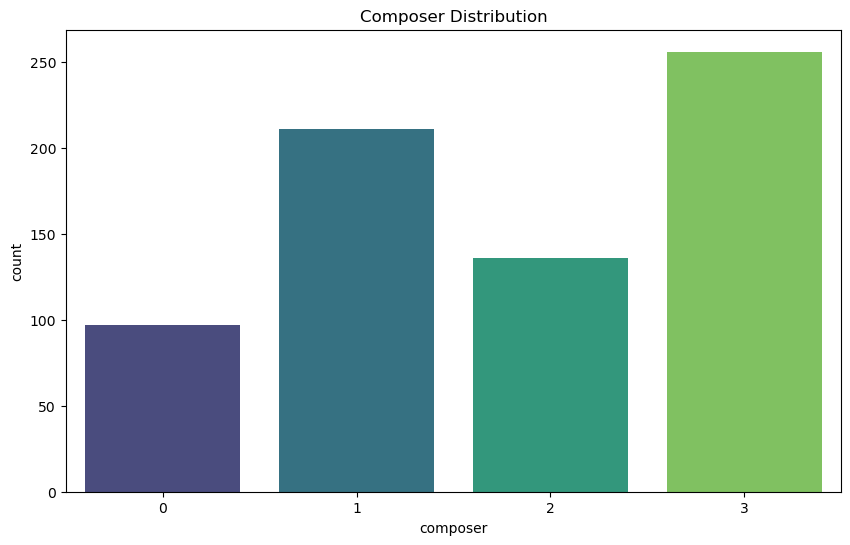

In [67]:
# plot composer distribution, add color for each composer
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='composer', palette='viridis')
plt.title('Composer Distribution')
plt.show()

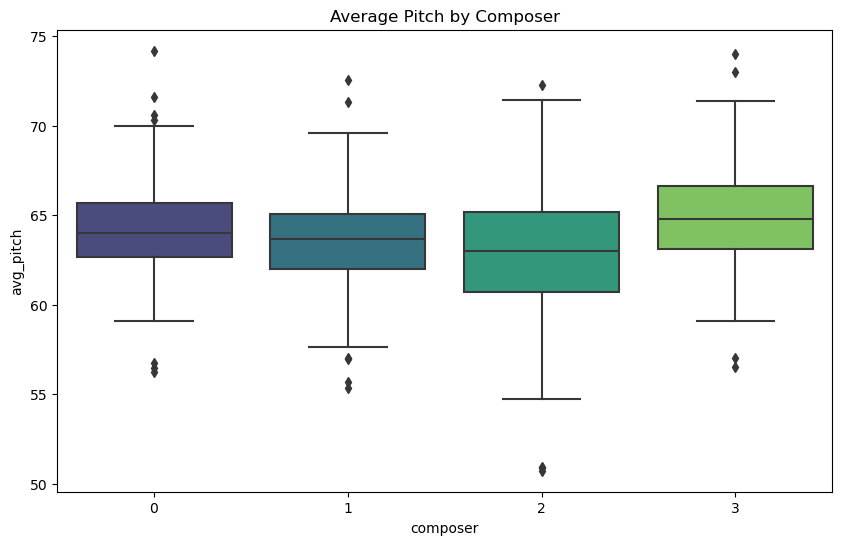

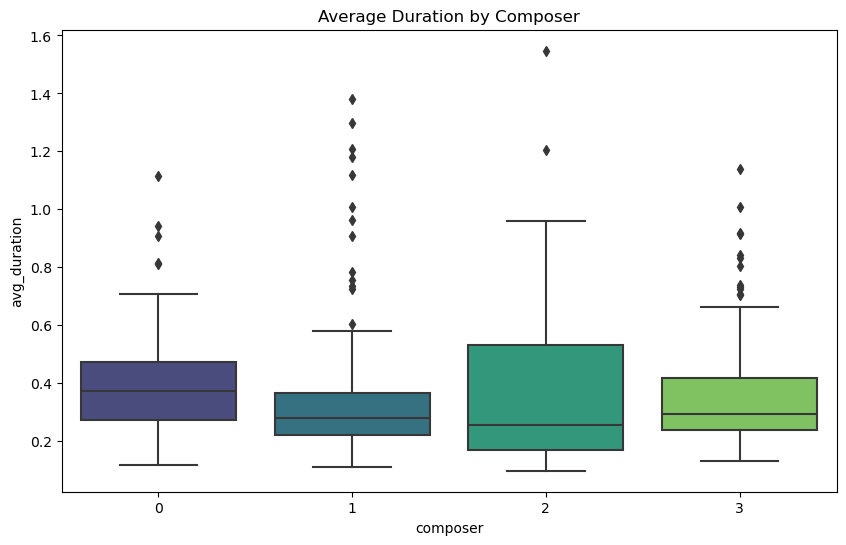

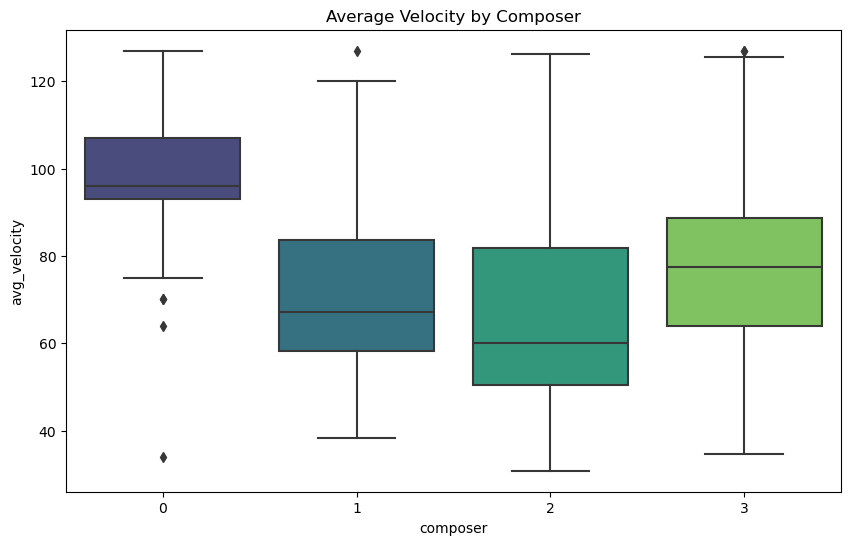

In [68]:
# plot average pitch for each composer
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='composer', y='avg_pitch', palette='viridis')
plt.title('Average Pitch by Composer')
plt.show()

# plot average duration for each composer
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='composer', y='avg_duration', palette='viridis')
plt.title('Average Duration by Composer')
plt.show()

# plot average velocity for each composer
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='composer', y='avg_velocity', palette='viridis')
plt.title('Average Velocity by Composer')
plt.show()

In [ ]:
##LSTM - Data Preprocessing (Address Class Imbalance)

In [14]:
# Prepare the dataset
X = df.drop(columns=['composer'])
y = df['composer']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets 
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X, y, test_size=0.2, random_state=42)

display(X_train_rs.head())

,duration,tempo,avg_velocity,max_velocity,min_velocity,std_velocity,avg_pitch,max_pitch,min_pitch,pitch_std,avg_duration,max_duration,min_duration,duration_std,pitch_range,num_instruments,note_density,note_vector,duration_vector,velocity_vector
82,319.836364,127.666666,100.000000,100,100,0.000000,68.438923,87,36,14.756193,0.331094,2.418182,0.050000,0.202642,51,2,3.020294,"[52, 53, 49, 46, 48, 41, 43, 44, 43, 41, 46, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[100, 100, 100, 100, 100, 100, 100, 100, 100, ..."
51,263.753683,143.999885,107.000000,107,107,0.000000,63.708571,83,33,12.281183,0.251194,1.916668,0.026042,0.257226,50,2,3.980987,"[57, 57, 45, 38, 50, 49, 47, 49, 50, 47, 46, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[107, 107, 107, 107, 107, 107, 107, 107, 107, ..."
220,693.286404,71.075815,55.864100,73,35,7.659493,59.799547,84,36,9.057856,0.785149,9.831067,0.410958,0.879909,48,3,1.273644,"[55, 50, 51, 48, 46, 45, 48, 53, 46, 41, 46, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...","[63, 63, 63, 63, 63, 63, 63, 63, 61, 60, 60, 6..."
669,1496.441053,138.500102,87.494519,125,32,19.782811,67.219245,86,28,13.162414,0.227838,3.342854,0.046429,0.305364,58,6,4.389080,"[33, 33, 33, 33, 33, 33, 33, 33, 38, 38, 42, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[88, 95, 99, 95, 100, 97, 99, 95, 111, 98, 106..."
545,4040.634505,121.922346,81.987111,125,1,16.228025,64.101289,101,28,12.504108,0.283037,7.181811,0.037879,0.433369,73,14,3.533108,"[41, 41, 43, 43, 43, 43, 43, 43, 43, 43, 45, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[105, 105, 105, 105, 105, 105, 105, 105, 105, ..."


In [ ]:
##Undersampling

In [15]:
# Use RandomUnderSampler to handle class imbalance for training data

# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = rus.fit_resample(X_train_rs, y_train_rs)

# Convert resampled data back to DataFrame for easier handling
X_undersampled_df = pd.DataFrame(X_undersampled, columns=X.columns)
y_undersampled_df = pd.Series(y_undersampled, name='composer')

# Verify class distribution after undersampling
print(y_undersampled_df.value_counts())

# shape of y_undersampled_df
print(y_undersampled_df.shape)

0    72
1    72
2    72
3    72
Name: composer, dtype: int64
(288,)


In [ ]:
##Oversampling

In [16]:
# Use Random Oversampling by copying the minority class

# Perform random oversampling on the training set
ros = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = ros.fit_resample(X_train_rs, y_train_rs)

# Convert resampled data back to DataFrame for easier handling (optional)
X_oversampled_df = pd.DataFrame(X_oversampled, columns=X.columns)
y_oversampled_df = pd.Series(y_oversampled, name='composer')

# Display the resampled training set
print(y_oversampled_df.value_counts())

0    209
1    209
3    209
2    209
Name: composer, dtype: int64


In [ ]:
##LSTM - Data Preprocessing

In [17]:
# Extract and combine vector features for LSTM input from undersampled data
note_vectors = np.stack(X_undersampled_df['note_vector'].values)
duration_vectors = np.stack(X_undersampled_df['duration_vector'].values)
velocity_vectors = np.stack(X_undersampled_df['velocity_vector'].values)

# Combine vectors into 3D array: (num_samples, sequence_length, num_features)
X_train_vectors_un = np.stack((note_vectors, duration_vectors, velocity_vectors), axis=-1)

# Print shape of the input data 
print(f"X_train_vectors shape from undersamped data: {X_train_vectors_un.shape}")  # Should be (num_samples, sequence_length, num_features)


# Extract and combine vector features for LSTM input from oversampled data
note_vectors = np.stack(X_oversampled_df['note_vector'].values)
duration_vectors = np.stack(X_oversampled_df['duration_vector'].values)
velocity_vectors = np.stack(X_oversampled_df['velocity_vector'].values)

# Combine vectors into 3D array: (num_samples, sequence_length, num_features)
X_train_vectors_os = np.stack((note_vectors, duration_vectors, velocity_vectors), axis=-1)


# Repeat for test data
note_vectors_test = np.stack(X_test_rs['note_vector'].values)
duration_vectors_test = np.stack(X_test_rs['duration_vector'].values)
velocity_vectors_test = np.stack(X_test_rs['velocity_vector'].values)

X_test_vectors = np.stack((note_vectors_test, duration_vectors_test, velocity_vectors_test), axis=-1)

# Print shape of the training data
print(f"X_train_vectors shape from oversampled data: {X_train_vectors_os.shape}")  # Should be (num_samples, sequence_length, num_features)

# Print shape of the test data
print(f"X_test_vectors shape: {X_test_vectors.shape}")  # Should be (num_samples, sequence_length, num_features)

X_train_vectors shape from undersamped data: (288, 100, 3)
X_train_vectors shape from oversampled data: (836, 100, 3)
X_test_vectors shape: (140, 100, 3)


In [18]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    
    # Tuning the number of units in the first LSTM layer
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                   input_shape=(X_train_vectors_os.shape[1], X_train_vectors_os.shape[2]), 
                   return_sequences=True))
    
    # Tuning the number of units in the second LSTM layer
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32)))
    
    # Tuning the number of units in the Dense layer
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=256, step=32), 
                    activation='relu'))
    
    # Output layer
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    
    # Tuning the learning rate
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    optimizer = Adam(learning_rate=lr)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [31]:
# Assuming X_train_vectors_os and y_train_os are your original data
#X_train_vectors_os, X_val_vectors_os, y_train_os, y_val_os = train_test_split(
#    X_train_vectors_os, y_train_os, test_size=0.2, random_state=42
#)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=20,             # Number of different models to try
    executions_per_trial=2,    # Number of times to train each model
    directory='my_dir',
    project_name='lstm_optimization3'
)

Reloading Tuner from my_dir\lstm_optimization3\tuner0.json


In [46]:
# Split your data (example)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure shapes are aligned
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(560, 20) (560,)
(140, 20) (140,)


In [61]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    
    # Tuning the number of units in the first LSTM layer
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                   input_shape=(X_train_vectors_os.shape[1], X_train_vectors_os.shape[2]), 
                   return_sequences=True))
    
    # Tuning the number of units in the second LSTM layer
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32)))
    
    # Tuning the number of units in the Dense layer
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=256, step=32), 
                    activation='relu'))
    
    # Output layer
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    
    # Tuning the learning rate
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    optimizer = Adam(learning_rate=lr)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [62]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=20,             # Number of different models to try
    executions_per_trial=2,    # Number of times to train each model
    directory='my_dir',
    project_name='lstm_optimization'
)

Reloading Tuner from my_dir\lstm_optimization\tuner0.json


In [65]:
tuner.search(X_train, y_train, 
             validation_data4=(X_test, y_test), 
             epochs=10,  # You can increase the number of epochs
             batch_size=32)

In [66]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters: ", best_hyperparameters.values)

Best Hyperparameters:  {'units_1': 256, 'units_2': 192, 'dense_units': 96, 'learning_rate': 0.0001}


C:\Users\josep\anaconda3b\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
